# Natural Language Inference

## Data is in the form of: Premise, Hypothesis, Label
## Label taking the values 1 or 0 (1: entailment, 0: contradiction or neutrality)

### Import necessary libraries

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

### We will be using GloVe embeddings for this task to convert the words to vectors

### Please note that the glove embeddings are not included in the dataset. You can download the embeddings from the following link: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

### Or the mirror: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip

### Please specify the path to the embeddings in the code below

In [46]:
# Load GloVe embeddings
def load_glove_embeddings(embedding_path):
    print("Loading GloVe embeddings...")
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

In [47]:
# Function to create sentence embeddings

# The function is modelled after the approach described in "A large annotated corpus for learning natural language inference"
# by Samuel R. Bowman, Gabor Angeli, Christopher Potts, and Christopher D. Manning with a few modifications.
# The original aproach for their baseline model used a sum of word embeddings for each sentence. 
# We use the same approach but normalize the sum by dividing it by the number of words in the sentence.

def sentence_embedding(sentence, embeddings_index):
    words = sentence.split()
    embedding_dim = next(iter(embeddings_index.values())).shape[0]
    sentence_embedding = np.zeros(embedding_dim)
    for word in words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            sentence_embedding += embedding_vector
    return (sentence_embedding + 1) / (len(words) + 1)

In [48]:
# Create sentence embeddings index
embedding_path = "./input/embeddings/glove.6B/glove.6B.300d.txt"
embeddings_index = load_glove_embeddings(embedding_path)

Loading GloVe embeddings...
Loaded 400001 word vectors.


In [49]:
# Load the training data
data_path = "./data/train.csv"
df = pd.read_csv(data_path)

# Print rows with missing values or NaN
print(df[df.isnull().any(axis=1)])
print(df[df.isna().any(axis=1)])

# Replace missing values or NaN with empty strings
df = df.fillna('')
df = df.replace(np.nan, '', regex=True)

df

Empty DataFrame
Columns: [premise, hypothesis, label]
Index: []
Empty DataFrame
Columns: [premise, hypothesis, label]
Index: []


,premise,hypothesis,label
0,"However, Fort Charles was rebuilt as a militar...",Fort Charles was rebuilt as an amusement park ...,0
1,Buchanan's The Democrats and Republicans have...,THe parties will never be similar.,0
2,In order to review an acquisition that is usin...,The auditor only reviews the acquisition itsel...,0
3,Three young people sit outside and engage with...,There is a tin can and string telephone.,0
4,The lucrative tin mines of Kuala Lumpur in the...,The Chinese labor was seen as less costly and ...,1
...,...,...,...
26939,Information in agencies' plans and reports pro...,"Thanks to agencies' plans and reports, over $3...",0
26940,"He is the Mr. Magoo of scientific theory, geni...",He understands everything he can't see.,0
26941,"Over the past 25 years, the Postal Service has...",Classifying mail is important to the function ...,1
26942,Whoever first stepped ashore on Madeira discov...,The British discovered the Canary Islands first.,0


In [50]:
# Create sentence embeddings for the training data
premise_embeddings = [sentence_embedding(sentence.lower(), embeddings_index) for sentence in df['premise']]
hypothesis_embeddings = [sentence_embedding(sentence.lower(), embeddings_index) for sentence in df['hypothesis']]

### Train-Test Split

In [51]:
X = np.hstack((np.array(premise_embeddings), np.array(hypothesis_embeddings)))
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define the Model

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(600,)),  # input shape is twice the GloVe embedding dimension for premise and hypothesis
    tf.keras.layers.Dense(500, activation='tanh'),
    tf.keras.layers.Dense(400, activation='tanh'),
    tf.keras.layers.Dense(300, activation='tanh'),
    tf.keras.layers.Dense(300, activation='tanh'),
    tf.keras.layers.Dense(300, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adadelta',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Print number of model parameters
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 500)            │       300,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 400)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 300)            │       120,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,402 (3.29 MB)

 Trainable params: 862,402 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model and plot the training history at the end
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5309 - loss: 0.6924 - val_accuracy: 0.5710 - val_loss: 0.6809
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5696 - loss: 0.6795 - val_accuracy: 0.5923 - val_loss: 0.6716
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5887 - loss: 0.6735 - val_accuracy: 0.5965 - val_loss: 0.6661
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5946 - loss: 0.6679 - val_accuracy: 0.6002 - val_loss: 0.6618
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6023 - loss: 0.6637 - val_accuracy: 0.6109 - val_loss: 0.6597
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5995 - loss: 0.6635 - val_accuracy: 0.6187 - val_loss: 0.6575
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6125 - loss: 0.6580 - val_accuracy: 0.6127 - val_loss: 0.6535
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6099 - loss: 0.6581 - val_accu

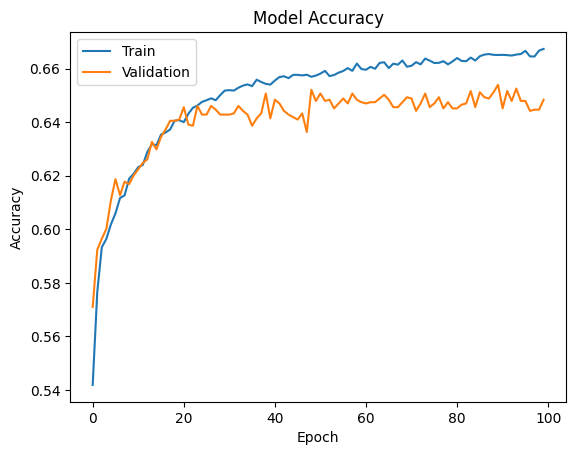

In [54]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# Number of epochs
print("Number of epochs: ", len(history.history['accuracy']))
# Seed
print("Seed: ", 42)
# Number of parameters
print("Number of parameters: ", model.count_params())

Number of epochs:  100
Seed:  42
Number of parameters:  862402


### Save the model

In [56]:
# Save the model
filename = "./models/deep_learning/model.keras"
model.save(filename)

In [42]:
# Load the model
# loaded_model = tf.keras.models.load_model(filename)